In this notebook, I will be using the data I worked on in the previous NBA season to see if I can find trends in how player price increases relative to player value.<br><br>
Basically, I want to see if i can find the expected price change the next game for a player, based on how valuable they were that previous game.<br>
An example of finding this out would be being able to guess player A's price in game 2, based on his value in game 1.

In [1]:
#pulling in all the necessary python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy.stats import zscore
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
#create frame from saved csv of table I scraped and cleaned from RotoGuru1
tight_frame = pd.read_csv('tight_frame.csv')
#rename columns
tight_frame.columns = ['Row','Date','Position','Name','Fanduel_Points','Fanduel_Price','Team','Minutes_Played','Home_or_Away','Opponent']
#I am making a data frame with most of the scores
#but ignoring zeroes for now since that means someone scored zero points and most likely did not play

In [3]:
#moving names to front column and changing frame name to avoid accidentally saving over the other one
#since I use tight_frame in the other notebook too
player_frame = tight_frame[['Name','Date','Position','Fanduel_Points','Fanduel_Price','Team','Minutes_Played','Home_or_Away','Opponent']].reset_index(drop=True)
#changing date column to date time
player_frame['Date'] =  pd.to_datetime(player_frame['Date'])
#creating a column with expected points scored based on price accoridng to Fanduel's value calculation
player_frame['Fanduel_Expected_Points'] = player_frame['Fanduel_Price'].apply(lambda x: round (x/1000,1))
#creating a column with Fanduel's value multiplier
player_frame['Fanduel_multiple'] = (player_frame['Fanduel_Points']/player_frame['Fanduel_Expected_Points'])
#removing all Zeros of fanduel multiple since it means somebody didn't play
no_zeros = player_frame[player_frame['Fanduel_multiple'] != 0].reset_index(drop=True)

In [4]:
#filtering for just the NBA 2020 season
#I discovered that my data cleaning had pulled information from both the 2018-2019 season and from the playoffs,
#which I do not want, so I'm pulling those out here
no_zeros['Date'] = pd.to_datetime(no_zeros['Date'])
#setting dates for Oct 22 2019 and March 10 2020 which is when the season began and then when the season shut down due to COVID
start_date = '10-22-2019'
end_date = '3-10-2020'
#creating filtered column of those dates
no_zeros['mask'] = (no_zeros['Date'] >= start_date) & (no_zeros['Date'] <= end_date)
#now I'm filtering for dates in this season
multiples = no_zeros[no_zeros['mask'] != False].reset_index(drop=True)

In [5]:
#create a version of this series grouped by player name and date
#creating series that has player and date with points
player_points = multiples.groupby(['Name','Date']).Fanduel_Points.mean()
#creating series that has player and date with points
player_price = multiples.groupby(['Name','Date']).Fanduel_Price.mean()
#creating series that has player and date with points
player_expValue = multiples.groupby(['Name','Date']).Fanduel_Expected_Points.mean()
#creating series that has player and date with points
player_RealValue = multiples.groupby(['Name','Date']).Fanduel_multiple.mean()
#creating series that has player and date with points
player_minutes_total = multiples.groupby(['Name','Date']).Minutes_Played.mean()
#concat into one table
player_table = pd.concat([player_points,player_expValue,player_RealValue,\
                        player_price,player_minutes_total],axis=1).reset_index()

In [6]:
#Creating a Column Previous Value that will contain the value provided by the player in their last game
#for now, it will have their value for that specific week
player_table['Prev_Value'] = player_table['Fanduel_multiple']
#adding whether a game was Home as a 1 or Away as a 0 since Fanduel claims to account for it in determining price
player_table['Home'] = multiples['Home_or_Away'].apply(lambda x: 1 if str(x) == 'Home' else 0)

In [7]:
#Ensuring my column names are correct before adding more
player_table.columns = ['Name','Date','Fanduel_Points','Fanduel_Expected_Points',\
                        'Fanduel_multiple','Fanduel_Price','Minutes_Played','Prev_Value','Home']
#I am also now going to remove any player who appears less than 5 times
#If somebody only played 5 games this season, I am just not interested in them and do not want them to throw off my numbers
trimmedplayer_table = player_table.groupby('Name').filter(lambda x : len(x)>4).reset_index(drop=True)

In [8]:
#now, I have my table in order by players and then by dates. I want to write a loop that will check for a players name 
#if it is the same as the previous row, it will place the previous week's value
#if it is a new name, it place the player's value they scored that week
#Creating list with just the first value
Result = [2.767123]
#writing comprehension to update previous value after checking on name change
def prev_value(df):
    #loop checking if name changes
    for i in range(1,len(df)):
        #if name for new row matches name for last row, then list value from last row
        if df.Name[i] == df.Name[i-1]:
            Result.append(df.Fanduel_multiple[i-1])
        #if name for new row does not match name for last row, then use value from that game
        elif df.Name[i] != df.Name[i-1]:
            Result.append(df.Fanduel_multiple[i])
#running comprehnesion to create list of previous values
prev_value(trimmedplayer_table)
#adding that list to my frame as a new column
trimmedplayer_table['Prev_Value'] = Result

#Repeating this for price and for points

#Points first
Points = [20.2]
#writing comprehension to update previous points after checking on name change
def prev_points(df):
    #loop checking if name changes
    for i in range(1,len(df)):
        #if name for new row matches name for last row, then list value from last row
        if df.Name[i] == df.Name[i-1]:
            Points.append(df.Fanduel_Points[i-1])
        #if name for new row does not match name for last row, then use value from that game
        elif df.Name[i] != df.Name[i-1]:
            Points.append(df.Fanduel_Points[i])
#running comprehnesion to create list of previous values
prev_points(trimmedplayer_table)
#adding that list to my frame as a new column
trimmedplayer_table['Prev_Points'] = Points
#Now Price
Price = [7300]
#writing comprehension to update previous points after checking on name change
def prev_price(df):
    #loop checking if name changes
    for i in range(1,len(df)):
        #if name for new row matches name for last row, then list value from last row
        if df.Name[i] == df.Name[i-1]:
            Price.append(df.Fanduel_Price[i-1])
        #if name for new row does not match name for last row, then use value from that game
        elif df.Name[i] != df.Name[i-1]:
            Price.append(df.Fanduel_Price[i])
#running comprehension to create list of previous values
prev_price(trimmedplayer_table)
#adding that list to my frame as a new column
trimmedplayer_table['Prev_Price'] = Price

In addition to just the previous score, I am going to add a three game rolling average and 5 game rolling average for Value, Points, and Stats to see if those have a any stronger correlation to price.

In [9]:
#now, I'd like to add a rolling average for each as well so we are using more than just the previous day's performance
#3 day rolling average of value
trimmedplayer_table['3_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#3 day rolling average of Points
trimmedplayer_table['3_Game_Points']=trimmedplayer_table.groupby('Name').Prev_Points.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#3 day rolling average of Price
trimmedplayer_table['3_Game_Price']=trimmedplayer_table.groupby('Name').Prev_Price.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#5 day rolling average of value
trimmedplayer_table['5_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#10 day rolling average of value
trimmedplayer_table['10_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))
#15 day rolling average of value
trimmedplayer_table['15_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(15,min_periods=1).mean().fillna(x))
#5 day rolling average of Points
trimmedplayer_table['5_Game_Points']=trimmedplayer_table.groupby('Name').Prev_Points.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#5 day rolling average of Price
trimmedplayer_table['5_Game_Price']=trimmedplayer_table.groupby('Name').Prev_Price.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#Also adding rolling minutes
#3 day rolling average of Minutes
trimmedplayer_table['3_Game_Minutes']=trimmedplayer_table.groupby('Name').Minutes_Played.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#5 day rolling average of Minutes
trimmedplayer_table['5_Game_Minutes']=trimmedplayer_table.groupby('Name').Minutes_Played.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))

Now that I have my columns set up, I'm going to try to see if we can set up a model to project a player's price based on their previous scores. We can then compare it to a test sample to see how close we get.

In [10]:
#taking some measures of centrality
trimmedplayer_table.describe()

,Fanduel_Points,Fanduel_Expected_Points,Fanduel_multiple,Fanduel_Price,Minutes_Played,Prev_Value,Home,Prev_Points,Prev_Price,3_Game_Value,3_Game_Points,3_Game_Price,5_Game_Value,10_Game_Value,15_Game_Value,5_Game_Points,5_Game_Price,3_Game_Minutes,5_Game_Minutes
count,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000,19767.000000
mean,22.047721,5.035372,4.242784,5035.372085,23.509251,4.234166,0.499418,22.013588,5036.525522,4.209129,21.897223,5037.655352,4.195239,4.169078,4.146704,21.838524,5038.885769,23.409940,23.363016
std,14.125654,1.854100,2.204145,1854.099868,9.730137,2.202550,0.500012,14.131187,1857.714002,1.569952,12.236667,1847.895686,1.398370,1.260147,1.209132,11.807481,1842.871373,8.818980,8.573799
min,-2.000000,3.500000,-0.571429,3500.000000,0.000000,-0.571429,0.000000,-2.000000,3500.000000,-0.571429,-2.000000,3500.000000,-0.571429,-0.571429,-0.571429,-2.000000,3500.000000,0.333333,0.333333
25%,11.100000,3.600000,2.662603,3600.000000,16.475000,2.652476,0.000000,11.100000,3600.000000,3.207882,12.700000,3600.000000,3.367857,3.476301,3.487368,13.040000,3620.000000,16.872222,16.946667
50%,20.100000,4.300000,4.182796,4300.000000,24.200000,4.175439,0.000000,20.100000,4300.000000,4.338809,20.200000,4300.000000,4.375356,4.411932,4.419981,20.200000,4280.000000,24.011111,24.006667
75%,30.900000,5.800000,5.641026,5800.000000,31.316667,5.628239,1.000000,30.800000,5800.000000,5.248986,29.183333,5833.333333,5.127236,5.002369,4.944444,28.760000,5820.000000,30.722222,30.543333
max,88.400000,15.500000,16.428571,15500.000000,51.550000,16.428571,1.000000,88.400000,15500.000000,11.085714,81.600000,13100.000000,11.085714,11.085714,11.085714,81.600000,12680.000000,44.983333,44.983333


In [11]:
#using .corr() to eyeball how certain factors seem to line up
trimmedplayer_table.corr()

,Fanduel_Points,Fanduel_Expected_Points,Fanduel_multiple,Fanduel_Price,Minutes_Played,Prev_Value,Home,Prev_Points,Prev_Price,3_Game_Value,3_Game_Points,3_Game_Price,5_Game_Value,10_Game_Value,15_Game_Value,5_Game_Points,5_Game_Price,3_Game_Minutes,5_Game_Minutes
Fanduel_Points,1.000000,0.700469,0.788793,0.700469,0.768378,0.288565,-0.001592,0.606469,0.694388,0.362934,0.673248,0.692550,0.406746,0.439068,0.449892,0.695666,0.692071,0.609071,0.617908
Fanduel_Expected_Points,0.700469,1.000000,0.167313,1.000000,0.599604,0.240174,0.010484,0.749891,0.977785,0.357486,0.867144,0.965611,0.394730,0.426119,0.438686,0.890308,0.962725,0.698391,0.713329
Fanduel_multiple,0.788793,0.167313,1.000000,0.167313,0.615155,0.238427,-0.011853,0.247818,0.171136,0.251275,0.244635,0.177105,0.284019,0.304961,0.311000,0.255879,0.178497,0.312673,0.312474
Fanduel_Price,0.700469,1.000000,0.167313,1.000000,0.599604,0.240174,0.010484,0.749891,0.977785,0.357486,0.867144,0.965611,0.394730,0.426119,0.438686,0.890308,0.962725,0.698391,0.713329
Minutes_Played,0.768378,0.599604,0.615155,0.599604,1.000000,0.365462,-0.001493,0.584980,0.594792,0.447575,0.635299,0.588890,0.489961,0.522075,0.531929,0.649969,0.587772,0.774113,0.779074
Prev_Value,0.288565,0.240174,0.238427,0.240174,0.365462,1.000000,0.006081,0.788378,0.168178,0.308479,0.275682,0.176537,0.332504,0.354139,0.359317,0.279687,0.178130,0.448381,0.404514
Home,-0.001592,0.010484,-0.011853,0.010484,-0.001493,0.006081,1.000000,0.011388,0.008759,0.004617,0.010934,0.008043,-0.002832,-0.001448,-0.003559,0.007485,0.009530,0.001491,0.001642
Prev_Points,0.606469,0.749891,0.247818,0.749891,0.584980,0.788378,0.011388,1.000000,0.701460,0.397248,0.697040,0.698115,0.436814,0.470755,0.480844,0.715143,0.696972,0.698253,0.679672
Prev_Price,0.694388,0.977785,0.171136,0.977785,0.594792,0.168178,0.008759,0.701460,1.000000,0.351069,0.869274,0.975783,0.392615,0.424365,0.436233,0.894846,0.971668,0.687758,0.709164
3_Game_Value,0.362934,0.357486,0.251275,0.357486,0.447575,0.308479,0.004617,0.397248,0.351069,1.000000,0.736340,0.276484,0.888848,0.789516,0.755774,0.630545,0.267655,0.639160,0.622482


Looking at this table, it seems like we may not see too much of a correlation in our model, but let's play it out

In [15]:
#Creating a frame of all my factors I want to weigh in to how price is calculated
X = trimmedplayer_table[['Prev_Value','Home','Prev_Points',\
                         '3_Game_Value', '3_Game_Points',\
                         '5_Game_Value','5_Game_Points', '3_Game_Minutes',\
                         '5_Game_Minutes','10_Game_Value','15_Game_Value']]
#creating frame of prices as my dependent variable
y = trimmedplayer_table['Fanduel_Price']
#Creating test split and train split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=6)
#creating variable for linear regression method
lm = LinearRegression()
#creating model based on my training split of the data I have pulled
model = lm.fit(x_train, y_train)
#creating a set of y predictions from my test content
y_predict= lm.predict(x_test)
#scoring of model based just on my training
print("Train score:")
print(lm.score(x_train, y_train))
#scoring of my model with test content
print("Test score:")
print(lm.score(x_test, y_test))

Train score:
0.9476495791247945
Test score:
0.9478141513021568


The scores to guess price actually look fairly good once we apply them! I'm going to plot the test here to get a visual.

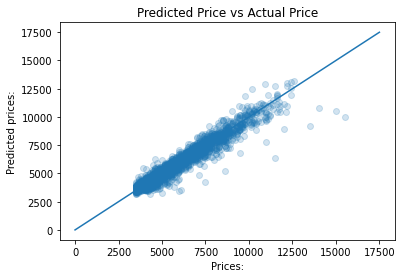

In [13]:
#creating scatter plot comparing my test values
plt.scatter(y_test, y_predict, alpha=.2)
plt.plot(range(17500), range(17500))

plt.xlabel("Prices:")
plt.ylabel("Predicted prices:")
plt.title("Predicted Price vs Actual Price")

plt.show()

Looking at the plot, it seems like my model has an issue where it is more likely to undervalue a player compared to the price chosen by Fanduel.

Now I want to do something similar for Value. 

In [14]:
#Creating a frame of all my factors I want to weigh in to how value is calculated
X2 = trimmedplayer_table[['Fanduel_Price','Prev_Price','Prev_Points','Prev_Value',\
                         '3_Game_Price', '3_Game_Points',\
                         '5_Game_Value','5_Game_Points', '3_Game_Minutes',\
                         '5_Game_Minutes','5_Game_Price','10_Game_Value','15_Game_Value']]
#creating frame of prices as my dependent variable
y2 = trimmedplayer_table['Fanduel_multiple']
#Creating test split and train split
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.8, test_size = 0.2, random_state=6)
#creating variable for linear regression method
lm2 = LinearRegression()
#creating model based on my training split of the data I have pulled
model2 = lm2.fit(x2_train, y2_train)
#creating a set of y predictions from my test content
y_predict2= lm2.predict(x2_test)
#scoring of model based just on my training
print("Train score:")
print(lm2.score(x2_train, y2_train))
#scoring of my model with test content
print("Test score:")
print(lm2.score(x2_test, y2_test))

Train score:
0.13846719487013504
Test score:
0.15148416125243402


It looks like our model is no good for predicting value. Next steps here would be seeing if we can involve stats somehow to determine if a certain kind of player can outperform their price consistently based on some other more specific indicator. i'll need to work on adding that to my dataframe first before I can continue my work here.